In [1]:
import sys
sys.path.append("../../../")

from smc.sampler import SMCsampler
from smc.prior import M71Prior
from smc.images import M71ImageModel
from smc.kernel import SingleComponentMH
from smc.aggregate import Aggregate

import torch

import matplotlib.pyplot as plt

import numpy as np

import pickle

from utils.misc import select_cuda_device

device = select_cuda_device()
torch.cuda.set_device(device)
torch.set_default_device(device)

Selected device 0, which has 10822 MB available.


We generate 800 synthetic 8x8-pixel images designed to emulate M71. We use the prior and image hyperparameters from `m71.ipynb`. We include sources in a padded region around the image because such sources will exist for many of the actual M71 tiles. To do so, we adjust the rate parameter of the count prior accordingly.

In [2]:
with open('data/params.pkl', 'rb') as f:
    params = pickle.load(f)

params

{'flux_alpha': 0.2095324275668239,
 'flux_lower': 0.25165176391601557,
 'flux_upper': 1804.6791992187502,
 'counts_rate': 1.9302325248718262,
 'background': 104.1486587524414,
 'adu_per_nmgy': 238.77052307128906,
 'psf_params': tensor([1.2674, 2.9369, 6.7734, 6.7684, 0.3780, 0.0586]),
 'noise_additive': 3.730366984200373e-07,
 'noise_multiplicative': 1.2142912149429321}

In [3]:
torch.manual_seed(0)
np.random.seed(0)

image_dim = 8

background = params["background"]
adu_per_nmgy = params["adu_per_nmgy"]
psf_params = params["psf_params"]
noise_additive = params["noise_additive"]
noise_multiplicative = params["noise_multiplicative"]

pad = 4

TruePrior = M71Prior(max_objects = 100,
                     counts_rate = params["counts_rate"] * ((image_dim + 2*pad)**2) / (image_dim**2),
                     image_height = image_dim,
                     image_width = image_dim,
                     flux_alpha = params["flux_alpha"],
                     flux_lower = params["flux_lower"],
                     flux_upper = params["flux_upper"],
                     pad = pad)

TrueImageModel = M71ImageModel(image_height = image_dim,
                               image_width = image_dim,
                               background = background,
                               adu_per_nmgy = adu_per_nmgy,
                               psf_params = psf_params,
                               noise_additive = noise_additive,
                               noise_multiplicative = noise_multiplicative)

(unpruned_counts, unpruned_locs, unpruned_fluxes,
 pruned_counts, pruned_locs, pruned_fluxes, images) = TrueImageModel.generate(Prior = TruePrior,
                                                                              num_images = 2*800)

We examine a few of the images:

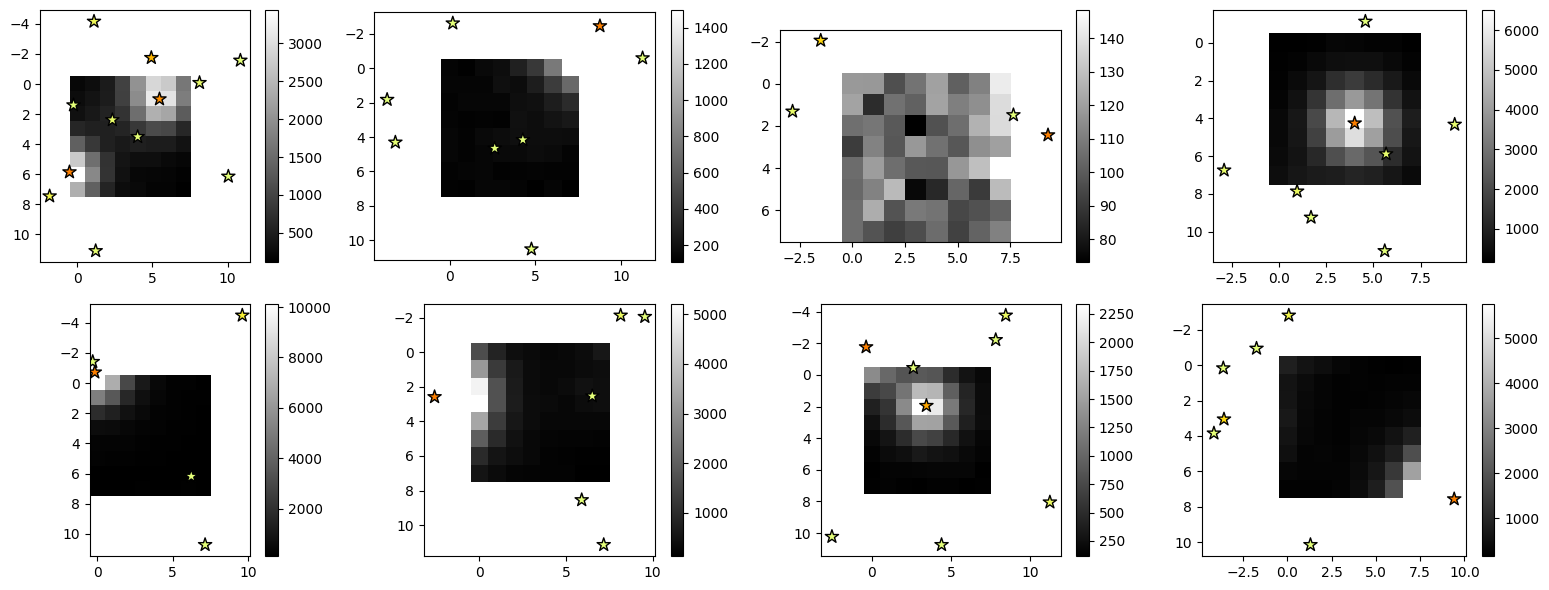

In [4]:
fig, ax = plt.subplots(2, 4, figsize = (16, 6))
np.random.seed(0)

for h in range(2):
    for w in range(4):
        idx = np.random.randint(0, 800)
        tmp = ax[h,w].imshow((images[idx]).cpu(), cmap = 'gray')
        _ = fig.colorbar(tmp, fraction = 0.045)
        _ = ax[h,w].scatter(unpruned_locs[idx].squeeze()[:unpruned_counts[idx].int().squeeze(),1].cpu() - 0.5,
                            unpruned_locs[idx].squeeze()[:unpruned_counts[idx].int().squeeze(),0].cpu() - 0.5,
                            c = unpruned_fluxes[idx].squeeze()[:unpruned_counts[idx].int().squeeze()].cpu(),
                            marker = '*', edgecolors = 'black', s = 100, cmap = 'Wistia')

fig.tight_layout()

We can do a couple of prior predictive checks. We first compare the distributions of the 0.1-quantile, median, and 0.9-quantile pixel intensities between our synthetic images and the real M71 images:

In [5]:
m71_tiles = torch.load("data/tiles.pt").to(device)

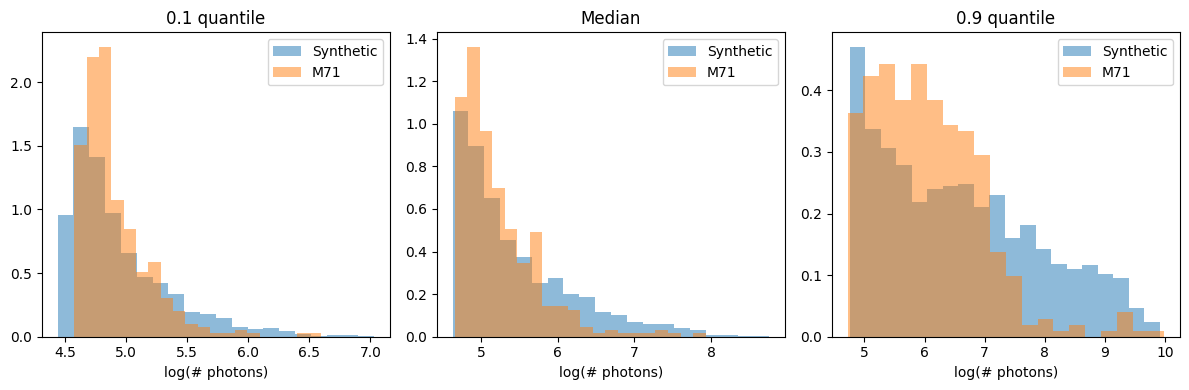

In [6]:
fig, ax = plt.subplots(1, 3, figsize = (12, 4))

_ = ax[0].hist(images.flatten(-2,-1).log().quantile(0.1, dim=-1).cpu(), label = 'Synthetic',
               density = True, bins = 20, alpha = 0.5)
_ = ax[0].hist(m71_tiles.flatten(-2,-1).log().quantile(0.1, dim=-1).cpu(), label = "M71",
               density = True, bins = 20, alpha = 0.5)
_ = ax[0].set_title('0.1 quantile')
_ = ax[0].set_xlabel('log(# photons)')
_ = ax[0].legend()

_ = ax[1].hist(images.flatten(-2,-1).log().median(-1).values.cpu(), label = 'Synthetic',
               density = True, bins = 20, alpha = 0.5)
_ = ax[1].hist(m71_tiles.flatten(-2,-1).log().median(-1).values.cpu(), label = "M71",
               density = True, bins = 20, alpha = 0.5)
_ = ax[1].set_title('Median')
_ = ax[1].set_xlabel('log(# photons)')
_ = ax[1].legend()

_ = ax[2].hist(images.flatten(-2,-1).log().quantile(0.9, dim=-1).cpu(), label = 'Synthetic',
               density = True, bins = 20, alpha = 0.5)
_ = ax[2].hist(m71_tiles.flatten(-2,-1).log().quantile(0.9, dim=-1).cpu(), label = "M71",
               density = True, bins = 20, alpha = 0.5)
_ = ax[2].set_title('0.9 quantile')
_ = ax[2].set_xlabel('log(# photons)')
_ = ax[2].legend()

fig.tight_layout()

---

We'll run our count-stratified sequential Monte Carlo algorithm to catalog one of the images:

Number of stars within image boundary: 3
Total intrinsic flux of stars within image boundary: 48.13930130004883
Total observed flux: 16862.0


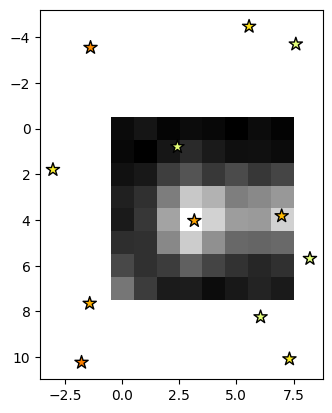

In [7]:
torch.manual_seed(0)
idx = torch.randint(low = 0, high = images.shape[0], size = [])
_ = plt.imshow((images[idx]).cpu(), cmap = 'gray')
_ = plt.colorbar(tmp, fraction = 0.045)
_ = plt.scatter(unpruned_locs[idx].squeeze()[:unpruned_counts[idx].int().squeeze(),1].cpu() - 0.5,
                unpruned_locs[idx].squeeze()[:unpruned_counts[idx].int().squeeze(),0].cpu() - 0.5,
                c = unpruned_fluxes[idx].squeeze()[:unpruned_counts[idx].int().squeeze()].cpu(),
                marker = '*', edgecolors = 'black', s = 100, cmap = 'Wistia')

print(f'Number of stars within image boundary: {pruned_counts[idx]}')
print(f'Total intrinsic flux of stars within image boundary: {pruned_fluxes[idx].sum(-1)}')
print(f'Total observed flux: {images[idx].sum().round()}')

In [8]:
tile_dim = 8
pad = 1

TilePrior = M71Prior(max_objects = 6,
                     counts_rate = params["counts_rate"] * ((tile_dim + 2*pad)**2 / (tile_dim**2)),
                     image_height = tile_dim,
                     image_width = tile_dim,
                     flux_alpha = params["flux_alpha"],
                     flux_lower = params["flux_lower"],
                     flux_upper = params["flux_upper"],
                     pad = pad)

TileImageModel = M71ImageModel(image_height = tile_dim,
                               image_width = tile_dim,
                               background = background,
                               adu_per_nmgy = adu_per_nmgy,
                               psf_params = psf_params,
                               noise_additive = noise_additive,
                               noise_multiplicative = noise_multiplicative)

MHKernel = SingleComponentMH(num_iters = 100,
                             locs_stdev = 0.1,
                             fluxes_stdev = 5,
                             fluxes_min = TilePrior.flux_lower,
                             fluxes_max = TilePrior.flux_upper)

In [9]:
torch.manual_seed(0)

sampler = SMCsampler(image = images[idx],
                     tile_dim = tile_dim,
                     Prior = TilePrior,
                     ImageModel = TileImageModel,
                     MutationKernel = MHKernel,
                     num_catalogs_per_count = 10000,
                     ess_threshold_prop = 0.5,
                     resample_method = "multinomial",
                     max_smc_iters = 100,
                     print_every = 2)

sampler.run()

starting the tile samplers...
iteration 2: temperature in [0.0, 0.0], acceptance rate in [0.64, 0.64]
iteration 4: temperature in [0.0, 0.0], acceptance rate in [0.73, 0.73]
iteration 6: temperature in [0.01, 0.01], acceptance rate in [0.71, 0.71]
iteration 8: temperature in [0.02, 0.02], acceptance rate in [0.69, 0.69]
iteration 10: temperature in [0.04, 0.04], acceptance rate in [0.64, 0.64]
iteration 12: temperature in [0.09, 0.09], acceptance rate in [0.54, 0.54]
iteration 14: temperature in [0.22, 0.22], acceptance rate in [0.42, 0.42]
iteration 16: temperature in [0.44, 0.44], acceptance rate in [0.34, 0.34]
iteration 18: temperature in [0.86, 0.86], acceptance rate in [0.29, 0.29]
done!



Now we instantiate an `Aggregate` object and resample the catalogs we sampled above. The `Aggregate` object isn't doing much work here at all, but it's helpful when we run our procedure on images partitioned into tiles.

In [10]:
aggMH = SingleComponentMH(num_iters = 100,
                          locs_stdev = 0.1,
                          fluxes_stdev = 5,
                          fluxes_min = TilePrior.flux_lower,
                          fluxes_max = TilePrior.flux_upper)

In [11]:
agg = Aggregate(sampler.Prior,
                sampler.ImageModel,
                aggMH,
                sampler.tiled_image,
                sampler.counts,
                sampler.locs,
                sampler.fluxes,
                sampler.weights_intercount,
                sampler.log_normalizing_constant,
                ess_threshold_prop = 0.5,
                resample_method = "multinomial")

agg.run()

aggregating tile catalogs...
done!



We summarize our results by reporting the posterior distribution over the number of stars within the image boundaries and the posterior mean of the total intrinsic flux:

In [12]:
agg.summarize()

summary:

posterior distribution of number of stars including padding:
tensor([4., 5., 6.])
tensor([0.0020, 0.2900, 0.7080]) 

posterior distribution of number of stars within image boundary:
tensor([2, 3, 4, 5, 6])
tensor([0.0920, 0.5970, 0.2710, 0.0390, 0.0010]) 

posterior mean total intrinsic flux including padding = 74.0

posterior mean total intrinsic flux within boundary = 50.0

number of unique catalogs = 17971


We can examine the posterior predictive distribution of the total observed flux. The dotted black line is the true total observed flux, computed by summing the intensities of all the pixels in the image. We expect 

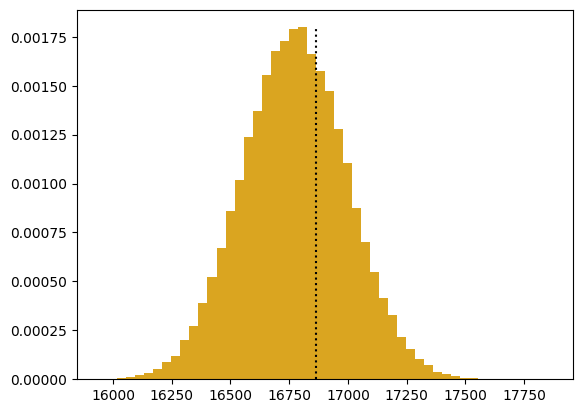

In [13]:
tmp = plt.hist(agg.posterior_predictive_total_observed_flux.squeeze().cpu(), bins = 50, density = True, color = 'goldenrod')
_ = plt.vlines(x = images[idx].sum().cpu(), ymin = 0, ymax = tmp[0].max(), color = 'black', linestyle = 'dotted')

We can also examine the posterior distribution of the total intrinsic flux of stars within the image boundary. The dotted black line is the ground truth. For images with stars near the boundary, this distribution will be multimodal. For each catalog, the total intrinsic flux within the boundary will depend on the locations of the stars near the boundary. We still expect credible intervals based on this distribution to achieve nominal frequentist coverage in the limit of infinite samples, but some modes may not be characterized well unless the number of samples is large.

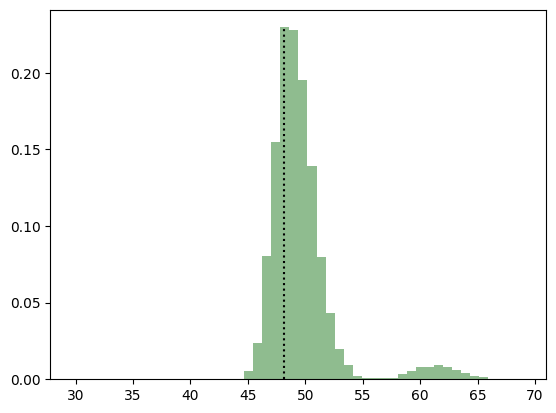

In [14]:
tmp = plt.hist(agg.pruned_fluxes.squeeze().sum(-1).cpu(), bins = 50, density = True, color = 'darkseagreen')
_ = plt.vlines(x = pruned_fluxes[idx].sum(-1).cpu(), ymin = 0, ymax = tmp[0].max(), color = 'black', linestyle = 'dotted')

We can also reconstruct the image using a few of our posterior samples:

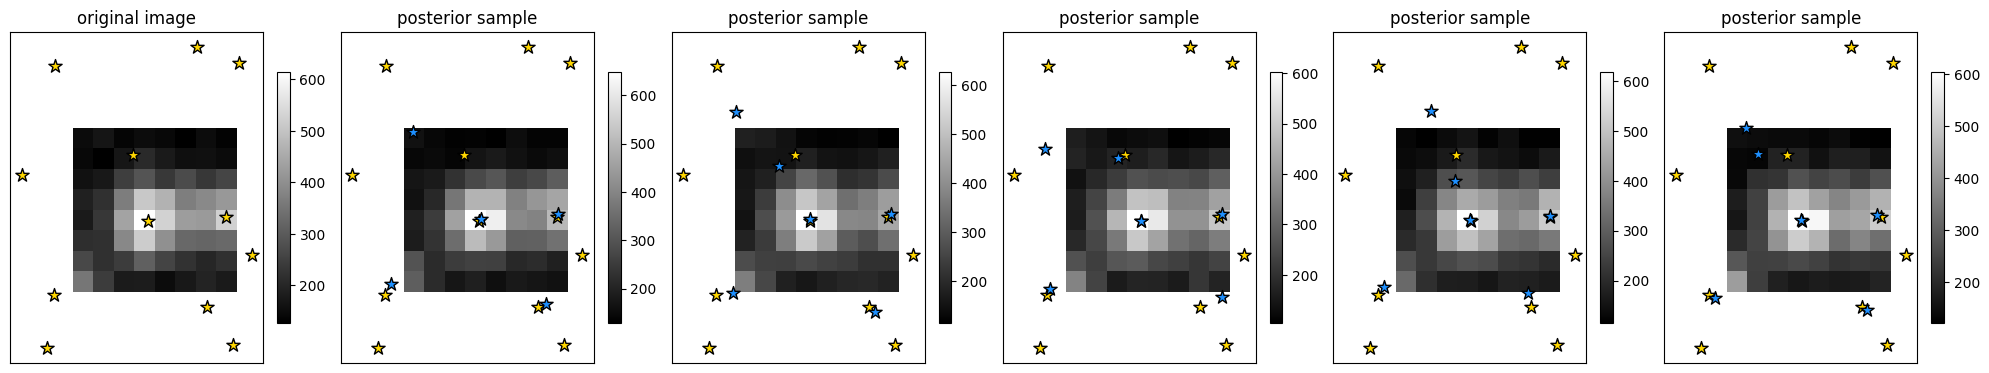

In [15]:
fig, ax = plt.subplots(1, 6, figsize = (20,4))
tmp = ax[0].imshow(images[idx].cpu(), cmap = 'gray')
_ = fig.colorbar(tmp, fraction = 0.045)
_ = ax[0].set_title('original image')
_ = ax[0].scatter(unpruned_locs[idx].squeeze()[:unpruned_counts[idx].int().squeeze(),1].cpu() - 0.5,
                  unpruned_locs[idx].squeeze()[:unpruned_counts[idx].int().squeeze(),0].cpu() - 0.5,
                  color = 'gold', marker = '*', edgecolors = 'black', s = 100)
_ = ax[0].set_xticks([])
_ = ax[0].set_yticks([])

for j in range(1,6):
    index = torch.randint(low = 0, high = agg.counts.shape[-1] - 1, size = [1])
    psf = agg.ImageModel.psf(agg.locs[:,:,index])
    rate = (psf * agg.ImageModel.adu_per_nmgy * agg.fluxes[:,:,index].unsqueeze(-3).unsqueeze(-4)).sum(-1) + agg.ImageModel.background
    reconstruction = torch.distributions.Poisson(rate).sample().squeeze([0,1]).permute((2,0,1))
    tmp = ax[j].imshow(reconstruction[0].cpu(), cmap = 'gray')
    _ = ax[j].set_title('posterior sample')
    _ = fig.colorbar(tmp, fraction = 0.045)
    _ = ax[j].scatter(unpruned_locs[idx].squeeze()[:unpruned_counts[idx].int().squeeze(),1].cpu() - 0.5,
                      unpruned_locs[idx].squeeze()[:unpruned_counts[idx].int().squeeze(),0].cpu() - 0.5,
                      marker = '*', color = 'gold', edgecolors = 'black', s = 100)
    _ = ax[j].scatter(agg.locs.squeeze()[index,:agg.counts.squeeze()[index].int(),1].cpu() - 0.5,
                      agg.locs.squeeze()[index,:agg.counts.squeeze()[index].int(),0].cpu() - 0.5,
                      marker = '*', color = 'dodgerblue', edgecolors = 'black', s = 100)
    _ = ax[j].set_xticks([])
    _ = ax[j].set_yticks([])

fig.tight_layout()

To assess the locations of light sources in our posterior catalogs, we plot a two-dimensional density plot of these locations and overlay them on the image:

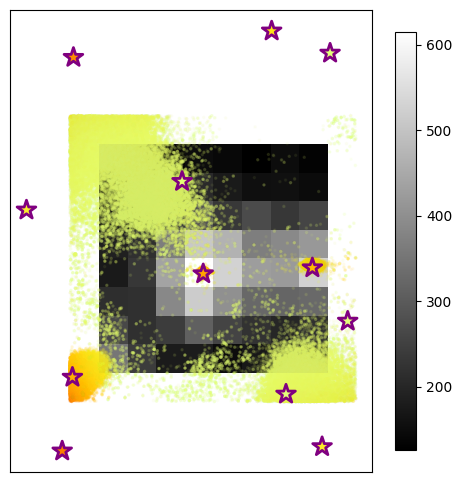

In [16]:
fig, ax = plt.subplots(1, 1, figsize = (6, 6))
tmp = ax.imshow(images[idx].cpu(), cmap = 'gray')
_ = fig.colorbar(tmp, fraction = 0.045)
_ = ax.scatter(agg.locs.squeeze()[...,1].cpu() - 0.5,
               agg.locs.squeeze()[...,0].cpu() - 0.5,
               c = agg.fluxes.squeeze().cpu(),
               marker = '.', cmap = 'Wistia', s = 10, alpha = 0.05)
_ = ax.scatter(unpruned_locs[idx].squeeze()[:unpruned_counts[idx].int(),1].cpu() - 0.5,
               unpruned_locs[idx].squeeze()[:unpruned_counts[idx].int(),0].cpu() - 0.5,
               c = unpruned_fluxes[idx].squeeze()[:unpruned_counts[idx].int()].cpu(),
               marker = '*', cmap = 'Wistia', edgecolors = 'purple', linewidth = 2, s = 200)
_ = ax.set_xticks([])
_ = ax.set_yticks([])